In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn import ensemble, metrics, linear_model
import random
%matplotlib inline

In [2]:
rnd=12
random.seed(rnd)
n_ft=15 #Number of features to add
max_elts=5

In [3]:
class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd = random_state
        self.n = n_neighbours
        self.max_elts = max_elts
        self.verbose = verbose
        self.neighbours = []
        self.clfs = []
        
    def fit(self, train, y):
        if self.rnd != None:
            random.seed(rnd)
        if self.max_elts == None:
            self.max_elts = len(train.columns)
        list_vars = list(train.columns)
        random.shuffle(list_vars)
        
        lastscores = np.zeros(self.n) + 1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars = list_vars[self.n:]
        
        for elt in list_vars:
            indice = 0
            scores = []
            for elt2 in self.neighbours:
                if len(elt2) < self.max_elts:
                    clf = linear_model.LinearRegression(fit_intercept=False, 
                                                        normalize=True, copy_X=True) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains = lastscores - scores
            if gains.max() > 0:
                temp = gains.argmax()
                lastscores[temp] = scores[temp]
                self.neighbours[temp].append(elt)

        indice = 0
        for elt in self.neighbours:
            clf = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice = indice + 1
                    
    def transform(self, train):
        indice = 0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)] = self.clfs[indice].predict(train[elt])
            indice = indice + 1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

In [4]:
train = pd.read_csv("data/train.csv")
target = train['target'].values
test = pd.read_csv("data/test.csv")
id_test = test['ID'].values

In [5]:
#train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
#test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
#train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
#test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
#train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
#test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
#train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
#test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v8','v23','v25','v31','v36','v37','v46',
                        'v51','v53','v54','v63','v73','v75','v79','v81','v82',
                        'v89','v92','v95','v105','v107','v108','v109','v110',
                        'v116','v117','v118','v119','v123','v124','v128']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

In [6]:
for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[train[elt] == 20] = -999
        test[test[elt] == 20] = -999
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)

In [7]:
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

0 0.602739434722 ['v5', 'v98', 'v18', 'v14', 'v50']
1 0.595501697576 ['v17', 'v71', 'v65', 'v94', 'v90']
2 0.810994034632 ['v83', 'v103', 'v87', 'v32', 'v93']
3 0.56572540597 ['v61', 'v19', 'v4', 'v91', 'v52']
4 1.49456076359 ['v121', 'v24', 'v120', 'v48', 'v85']
5 0.72309429408 ['v66', 'v129', 'v56', 'v35', 'v86']
6 0.592261091924 ['v44', 'v101', 'v64', 'v76', 'v29']
7 1.10813159468 ['v111', 'v40', 'v45', 'v130', 'v10']
8 0.59014496359 ['v27', 'v60', 'v28', 'v49', 'v126']
9 0.598807749711 ['v100', 'v38', 'v26', 'v67', 'v13']
10 0.559437953509 ['v114', 'v43', 'v97', 'v80', 'v11']
11 1.35177306603 ['v16', 'v69', 'v12', 'v113', 'v47']
12 0.666550798928 ['v15', 'v77', 'v78', 'v131', 'v33']
13 0.889217967428 ['v7', 'v57', 'v127', 'v3', 'v62']
14 1.59216441132 ['v112', 'v21', 'v6', 'v39', 'v125']


In [8]:
preds = list()
mf = 55
md = 35
for rnd in range(1):
    print(rnd, md, mf, flush=True)
    clf = ensemble.ExtraTreesClassifier(n_estimators=3750, max_features=mf ,criterion='entropy',
                                        min_samples_split=4, max_depth=md, min_samples_leaf=2, 
                                        n_jobs = -1, random_state=rnd)
    clf.fit(train,target)
    pred_et = clf.predict_proba(test)[:, 1]
    preds.append(pred_et)

0 35 55


In [12]:
np.array(preds)[0]

array([ 0.40670835,  0.89109065,  0.85985541, ...,  0.89307127,
        0.92975251,  0.55945507])

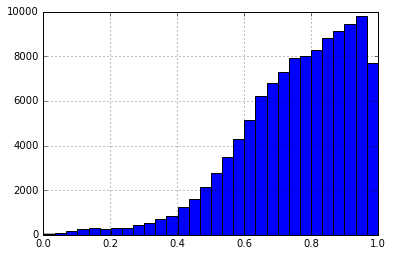

In [13]:
submission=pd.read_csv('data/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=np.array(preds)[0]#.mean(axis=0)
submission.to_csv('submission/et_ln_nbag.csv', index=False)
submission.PredictedProb.hist(bins=30)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

from sklearn import ensemble, metrics, linear_model
import random

#Some parameters to play with
rnd=12
random.seed(rnd)
n_ft=20 #Number of features to add
max_elts=3 #Maximum size of a group of linear features

class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)
    
    
train = pd.read_csv("../input/train.csv")
target = train['target'].values
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values

train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)
        
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

clf = ensemble.ExtraTreesClassifier(n_estimators=750,max_features=50,criterion= 'entropy',min_samples_split= 4,
                        max_depth= 35, min_samples_leaf= 2, n_jobs = -1, random_state=rnd)

clf.fit(train,target)
pred_et=clf.predict_proba(test)

submission=pd.read_csv('../input/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=pred_et[:,1]
submission.to_csv('./addNNLinearFt.csv', index=False)
submission.PredictedProb.hist(bins=30)